**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for personal scientific use. The crib sheet (or elements of the crib sheet) must not be ingested into third party libraries without written consent of the UCalgary team. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Loading, Calibrating, and Plotting Multi-Channel ASI Data**
---

### **Datasets**
Data from UCalgary geospace remote sensing projects can be found at https://data.phys.ucalgary.ca/. This crib sheet currently pertains to the following:
- TREx RGB
- *Rainbow ASI - Coming Soon*
- *SMILE ASI - Coming Soon*
</br>

### **Crib Sheet Summary**
The code and supporting documentation in this file present the basics of working with our multi-channel ASI data, specifically outlining
- Loading data
- Displaying single images
- Generating a movie
- Using image data to create keograms and ewograms
- Applying dark frame corrections to image data

</br>

---

</br>


## **Setup**

Install required dependencies using pip

In [1]:
!pip install trex-imager-readfile rainbow-imager-readfile matplotlib scipy requests joblib tqdm

In [2]:
# Before doing anything, one must install the readfile associated with the dataset they are interested in. In this case, we import the
# TREx and Rainbow imager readfiles for completeness, although one may opt to install only what is necessary.
#
# We will also require maplotlib, numpy, scipy, and opencv, so they are imported as well.

import os
import pprint
import glob
import os
import pprint
import trex_imager_readfile
import rainbow_imager_readfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
import requests
import joblib
from tqdm.notebook import tqdm

## **Downloading Data**

We need to download the data we're going to be using. UCalgary provides an API to help with this, and will be working further to make this process easier. You can learn more about how to use the API to download data by checking out the crib sheet for it on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible.

In [3]:
# set the top-level output path we want to save the files to
#
# NOTE: This crib sheet assumes you're using Google Colab. Change as needed.
download_root_path = "/content/ucalgary_data"

In [4]:
# These functions are helpers for downloading data, we won't go into any detail
# here, but just use them later on. Learn more by checking out the 'Downloading data
# from the API' crib sheet on data.phys.ucalgary.ca.

def download_url(url, prefix, output_base_path, overwrite=False, pbar=None):
    # set output filename
    output_filename = "%s/%s" % (output_base_path, url.removeprefix(prefix))
    if (overwrite is False and os.path.exists(output_filename)):
        if (pbar is not None):
            pbar.update()
        return

    # create destination directory
    try:
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    except Exception:
        # NOTE: sometimes when making directories in parallel there are race conditions. We put
        # in a catch here and carry on if there are ever issues.
        pass

    # retrieve file and save to disk
    r = requests.get(url)
    with open(output_filename, 'wb') as fp:
        fp.write(r.content)

    # advance progress bar
    if (pbar is not None):
        pbar.update()

def download_urls(dataset, urls, output_base_path, n_parallel=5, overwrite=False):
    prefix_to_strip = dataset["data_tree_url"]
    with tqdm(total=len(urls), desc="Downloading and saving files to disk") as pbar:
        joblib.Parallel(n_jobs=n_parallel, prefer="threads")(
            joblib.delayed(download_url)(
                urls[i],
                prefix_to_strip,
                os.path.join(output_base_path, dataset["name"]),
                overwrite=overwrite,
                pbar=pbar,
            ) for i in range(0, len(urls))
        )
    print("\nData saved to %s" % (output_base_path))

def get_data_urls(dataset_name, start, end, site_uid):
    params = {"name": dataset_name, "start": start, "end": end, "site_uid": site_uid, "include_total_bytes": True}
    r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/urls", params=params)
    data = r.json()
    return data

def list_datasets(name=None):
    if (name is not None):
        params = {"name": name}
        r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/datasets", params=params)
    else:
        r = requests.get("https://api.phys.ucalgary.ca/api/v1/data_distribution/datasets")
    datasets = r.json()
    return datasets

In [34]:
# We're going to download an hour of TREx RGB full-resolution raw data, specifically 2023-02-04 UT06 from
# the camera in Rabbit Lake, SK.
dataset_name = "TREX_RGB_STREAM0_RAW"
start = "2023-02-24T05:30"
end = "2023-02-24T06:29"
site_uid = "rabb"
dataset = list_datasets(name=dataset_name)[0]
urls = get_data_urls(dataset_name, start, end, site_uid)["urls"]
download_urls(dataset, urls, download_root_path)


Data saved to /content/ucalgary_data


## **Loading Data**

In [7]:
# To begin, let's grab a single minute's worth of RGB data, and then read it in using the readfile

# First requesting the particular datafile from data.phys.ucalgary.ca
image_file = os.path.join(download_root_path, dataset_name, '2023', '02', '24', 'rabb_rgb-06', 'ut06', '20230224_0620_rabb_rgb-06_full.h5')
img, meta, problematic_files = trex_imager_readfile.read_rgb(image_file)

In [8]:
# The first return value of the readfile, in this case 'img', contains the actual image data for the file passed as an argument, stored as a NumPy array.
# For a single 1-minute datafile, this NumPy array will contain some number of images - in the case of TREx RGB, which has an imaging cadence of 3 seconds,
# a single file will usually contain 20 images.

# For a single channel image, the first two dimensions will give you the size of an actual image, whereas the last will tell you the
# number of images/frames. Note that the last dimension will always be the number of images.
print("Type of 'img' variable:", type(img))
print("Dimensions of 'img' variable:", img.shape)
print("Image dimensions: %d x %d x %d" % (img.shape[0], img.shape[1], img.shape[2]))
print("Number of images: %d" % (img.shape[-1]))

# Notice that one image is 3 dimensional. In the case of TREx RGB, each image is 480 x 553 pixels, with a 3rd dimension pertaining to the R-G-B colour channels.

Type of 'img' variable: <class 'numpy.ndarray'>
Dimensions of 'img' variable: (480, 553, 3, 20)
Image dimensions: 480 x 553 x 3
Number of images: 20


In [10]:
# The second return value of the readfile, in this case 'meta', contains metadata pertaining directly to the image data. For a 1-minute
# file, the metadata will be returned as a list containing the same number of elements as the number of images contained in the file,
# usually 20 for TREx RGB. Each list element will give a dictionary, containing metadata pertaining to the image array of the corresponding index.

print("Type of 'meta' variable:", type(meta))
print("Length of 'meta' variable:", len(meta), "\n")

# For example, one can obtain information about the first frame as follows.
print("First image Metadata:")
first_frame_meta = meta[0]
pprint.pprint(first_frame_meta)

Type of 'meta' variable: <class 'list'>
Length of 'meta' variable: 20 

First image Metadata:
{'aperture': '4.0',
 'camera_environment_temperature': '23.62 C',
 'camera_serial': '072722600029',
 'exposure_length': '3 seconds',
 'gain': '30.0 dB',
 'geographic_latitude': '58.227808',
 'geographic_longitude': '-103.680631',
 'image_effective_end_timestamp': '2023-02-24 06:20:02.980342 UTC',
 'image_effective_exposure_length': '00:00:02.880015 ms',
 'image_request_start_timestamp': '2023-02-24 06:20:00.100327 UTC',
 'imager_unique_id': 'rgb-06',
 'lens_serial': '5680000528',
 'mode_unique_id': 'full',
 'ntp_delay': '1.013',
 'ntp_jitter': '18.447',
 'ntp_offset': '-48.846',
 'ntp_target': '192.168.0.1',
 'num_averaged_subframes': '9',
 'project_unique_id': 'trex',
 'shutter_state': 'open',
 'site_unique_id': 'rabb',
 'white_balance': '4000 Kelvin'}


---

## **Plotting Single Images**

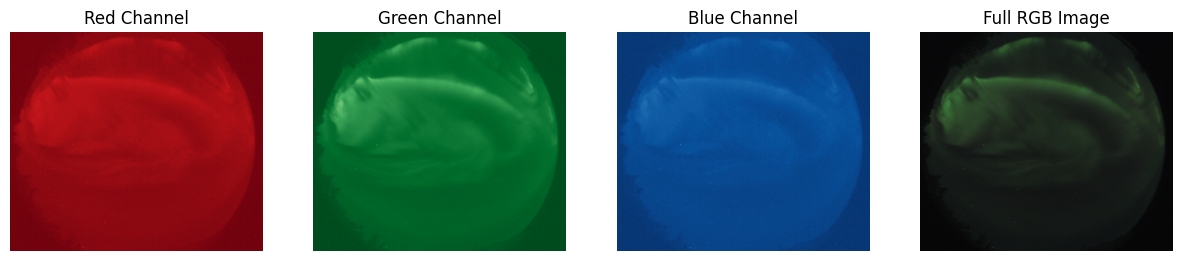

In [11]:
# Now that 1 minute of data has been loaded in, we can plot a single image.

# A single image can be obtained by slicing the image array - let's plot the first image
first_frame_img = img[:,:,:,0]

# We will also want the metadata that corresponds to this image.
first_frame_meta = meta[0]

# To further emphasize the fact that the image data is nothing more than a 3-dimensional array, notice
# that the red, green and blue channels can be sliced to obtain 2-D arrays of the individual color
# contributions to the total image.
red_channel = first_frame_img[:,:,0]
green_channel = first_frame_img[:,:,1]
blue_channel = first_frame_img[:,:,2]

# Each of the channels can be plotted individually using matplotlib imshow.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,15))
ax1.set_title("Red Channel")
ax1.imshow(red_channel, cmap='Reds_r', vmin=0, vmax=255)
ax1.axis('off')
ax2.set_title("Green Channel")
ax2.imshow(green_channel, cmap='Greens_r', vmin=0, vmax=255)
ax2.axis('off')
ax3.set_title("Blue Channel")
ax3.imshow(blue_channel, cmap='Blues_r', vmin=0, vmax=255)
ax3.axis('off')

# To display the full, RGB image, we simply pass the full 3 dimensional array as an arguement in our call to imshow.
ax4.imshow(first_frame_img, vmin=0, vmax=255)
ax4.set_title("Full RGB Image")
ax4.axis('off')
plt.show()

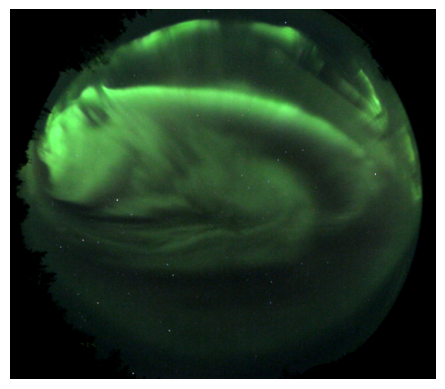

In [12]:
# The image is a bit dark; this is because in general, auroral phenomena will not use the full dynamic range of of the detector.
# Depending on the type of camera, or the phenomena you are interested in, you may wish to scale the data differently.
# We can manually scale the brightness up for plotting purposes, using the following function.

def scale_image(data, cmin=0, cmax=65535, low=0, high=65535):
    if high > 65535:
        raise ValueError("`high` should be less than or equal to 65535.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    else:
        cmin = float(cmin)
    if cmax is None:
        cmax = data.max()
    else:
        cmax = float(cmax)

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint16)

# Now, let's scale the image
scale_min = 15
scale_max = 100
scaled_first_frame_img = scale_image(first_frame_img, cmin=scale_min, cmax=scale_max, high=255)

# and then replot the image
plt.imshow(scaled_first_frame_img, cmap='gist_heat')
plt.axis('off')
plt.show()

# *** Note, depending on the imager and the type of activity in the FOV, you will need to play around
#     with the scaling floor and ceiling in order to achieve the desired result.

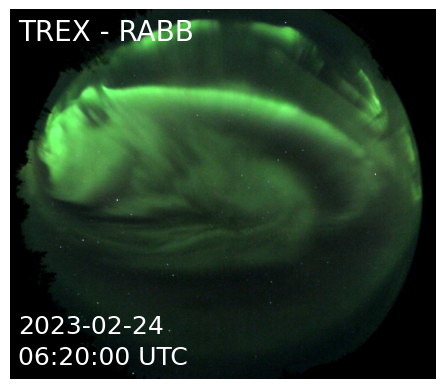

In [13]:
# Lastly, it is often useful to overplot some information about the image itself. This
# can be done easily using the image's accompanying metadata:
imager = first_frame_meta["project_unique_id"]
site = first_frame_meta["site_unique_id"]
timestamp = first_frame_meta["image_request_start_timestamp"]
date_string = timestamp[0:10]
time_string = timestamp[11:19]

# Now, let's replot the scaled image, this time overplotting our newly obtained
# metadata, to obtain our final product:
plt.imshow(scaled_first_frame_img)
plt.axis('off')
plt.text(10, 40, imager.upper()+' - '+site.upper(), color='white', fontsize=20)
plt.text(10, 420, date_string, color='white', fontsize=18)
plt.text(10, 460, time_string+' UTC', color='white', fontsize=18)
plt.show()

---

## **Generate a Movie**

In [27]:
# Now, with the ability to display single image 3-channel data arrays, one can generate
# a time series movie of the ASI's data.

# Let's generate a movie with a high temporal resolution, generating a frame for
# every 3 seconds of data, for 10 minutes of data.

# First, we must obtain this time period's data and read it in:
img_file_list = sorted(glob.glob(os.path.join(download_root_path, dataset_name, '2023', '02', '24', 'rabb_rgb-06', 'ut06', '20230224_061*_rabb_rgb-06_full.h5')))

img, meta, problematic_files = trex_imager_readfile.read_rgb(img_file_list, workers=os.cpu_count())

In [23]:
# A common way to generate a movie in Python is to first save all of the frames
# as individual images, and then string them together into a movie using the
# method of choice. We'll start by iteratively plotting the image data in
# matplotlib, and saving each one as a .png file:

# We'll store the frames in this directory:
if not os.path.exists("rgb_movie_frames"):
    os.mkdir("rgb_movie_frames")

#  We will want to overlay some information about each image when plotting. There a couple things that we
# can obtain right away from the first frame's metadata, as they will not change with time:
imager = meta[0]["project_unique_id"]
site = meta[0]["site_unique_id"]
first_timestamp = meta[0]["image_request_start_timestamp"]
date_string = first_timestamp[0:10]

n_imgs = img.shape[-1]
for i in tqdm(range(0,n_imgs), desc="Processing image frames"):
    # Index into the img array to obtain this iteration's 2-D image array, scale it, and grab the corresponding meta
    frame = scale_image(img[:,:,:,i], cmin=15, cmax=100, high=255)
    frame_meta = meta[i]

    # The metadata timestamp will change for each iteration, so we need to update it in each loop
    timestamp = frame_meta["image_request_start_timestamp"]
    time_string = timestamp[11:19]

    # Plot each frame using matplotlib
    plt.imshow(frame)
    plt.axis('off')
    plt.text(10, 40, imager.upper()+' - '+site.upper(), color='white', fontsize=20)
    plt.text(10, 420, date_string, color='white', fontsize=18)
    plt.text(10, 460, time_string+' UTC', color='white', fontsize=18)

    # Save each frame as a .png, in the directory we previously created
    plt.savefig("rgb_movie_frames/frame"+f'{i:03d}'+".png", bbox_inches='tight', pad_inches=0)
    plt.close()

# Now, the frames should be stored as .png files in the corresponding directory

Processing image frames:   0%|          | 0/200 [00:00<?, ?it/s]

In [24]:
# All that is left to do now, is combine the images into a movie. There are many
# different packages in Python that allow one to do this, here, we will use opencv

# First we will create a list containing all of the images. As we read in each image
# we will delete the file locally since we no longer need it, to clean up our workspace.
frame_list = []
for i in range(0, n_imgs):
    f = "rgb_movie_frames/frame"+f'{i:03d}'+".png"
    frame = cv2.imread(f)
    frame_list.append(frame)

    # Again, cleaning workspace
    os.remove(f)
os.rmdir('rgb_movie_frames')

# Before we initialize the video output, we require the size of the image frames. Since
# all of the frames are the same dimensions, we obtain them from the first frame:
width, height, n_channels = frame_list[0].shape

# Now we can initialize the video object, using the parameters of our choosing. Note
# that 'fourcc' is the tag for the codec that will be used for video compression.
movie_filename = 'MOVIE_20230224_gill_rgb.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 20
frame_size = (height, width)
movie = cv2.VideoWriter(movie_filename, fourcc, fps, frame_size)

# Now, all that is left to do is write the frames to the movie object and release it
for i in range(0, n_imgs):
    movie.write(frame_list[i])
movie.release()

# The movie should now be saved - you should be able to open and view it to
# verify that everything worked properly.

---

## **Create and Display Keograms and Ewograms**

In [35]:
# Keograms are a useful data product that can be generated from ASI image data. A keogram is created
# by stacking slices of the middle column of pixels from ASI images over a period of time.

# First, we must obtain this time period's data and read it in:
img_file_list = sorted(glob.glob(os.path.join(download_root_path, dataset_name, '2023', '02', '24', 'rabb_rgb-06', 'ut0*', '20230224_0*_rabb_rgb-06_full.h5')))

img, meta, problematic_files = trex_imager_readfile.read_rgb(img_file_list, workers=os.cpu_count())

# The img and meta variables will now contain data for the a 1-hour period
print("Image dimensions: %d x %d x %d" % (img.shape[0], img.shape[1], img.shape[2]))
print("Number of images: %d" % (img.shape[3]))
print("Length of 'meta' variable:", len(meta), "\n")

Image dimensions: 480 x 553 x 3
Number of images: 1200
Length of 'meta' variable: 1200 



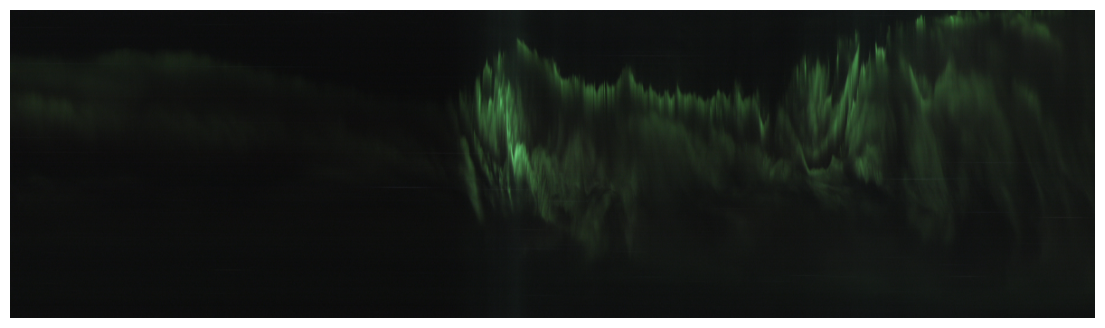

In [36]:
# To create a keogram from the data, we will need to iterate through each individual image,
# and take a slice of the middle column of pixels. Then we will need to add these slices together
# from left to right (so that time increases to the right). We will also have to account for the
# 3-dimensional nature of a RGB image.

# To begin, we can define an empty NumPy array that will be filled in with the keogram data. It's height
# will be the same as that of a single image, and the width will be determined by the number of images,
# given that we take a single column slice from each. The third dimension will be the number of colour channels:
n_rows = img.shape[0]
n_channels = img.shape[2]
n_imgs = img.shape[-1]
keogram = np.empty([n_rows, n_imgs, n_channels])

# It will also be useful to create a list of the timestamps for each slice (from the metadata) to use as an axis.
time_string_list = list()

# Now, we can iterate through each image within the hour, and slice the middle column, whose
# index is determined by the width of a single image:
middle_column_idx = int( (img.shape[1])/2 - 1)
for img_idx in range(0,n_imgs):

    # For each iteration, we slice into 'img' to obtain a single image
    # frame, and then slice into that to obtain the center column:
    frame = img[:,:,:,img_idx]
    frame_middle_slice = frame[:,middle_column_idx,:]

    # Then, we simply insert each image slice into the corresponding location in the keogram
    keogram[:,img_idx,:] = frame_middle_slice

    # Lastly, we update the list of time strings with that from the current iteration's metadata
    iter_meta = meta[img_idx]
    timestamp = iter_meta["image_request_start_timestamp"]
    time_string = timestamp[11:16]
    time_string_list.append(time_string)

# Once all images slices have been stacked into an array, we can simply plot it to show the keogram.
# For 3-channel color images, matplotlib's imshow function requires integer datatypes, so one must
# convert before plotting:
keogram = keogram.astype(np.uint8)
plt.figure(figsize=(14,4))
plt.imshow(keogram, aspect='auto')
plt.axis('off')
plt.show()

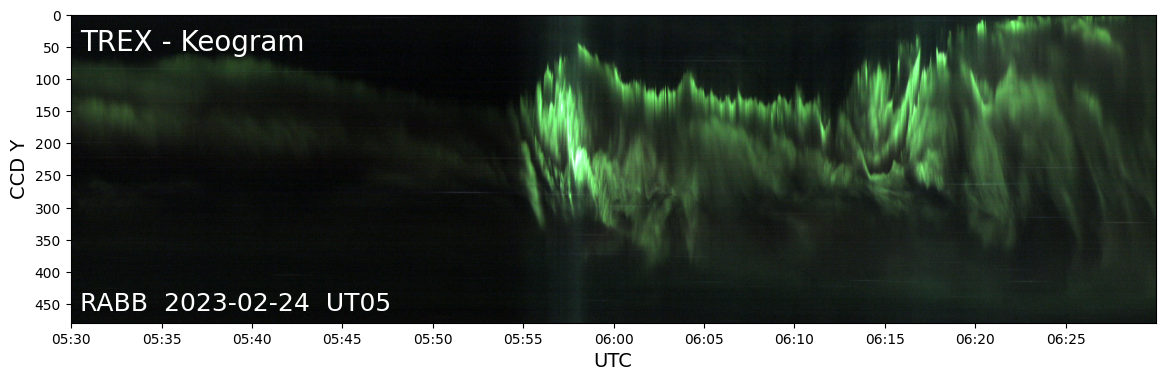

In [37]:
# Similar to as was done for a single image, we can scale the keogram up as desired, using the bytescale function
scaled_keogram = scale_image(keogram, cmin=10, cmax=100, high=255)

# We can also overplot some additional information about the keogram, which is easily obtainable from our metadata.
# These particular metadata fields will not change across the hour, so we can pull them from the first element of
# the full metadata_list:
imager = meta[0]["project_unique_id"]
site = meta[0]["site_unique_id"]
first_timestamp = meta[0]["image_request_start_timestamp"]
date_string = first_timestamp[0:10]
hour_string = first_timestamp[11:13]

# Now, we can replot the scaled image, with some additional information on top. We can also use
# the list of time strings we created as the horizontal axis:
plt.figure(figsize=(14,4))
plt.imshow(scaled_keogram, aspect='auto')
plt.text(10, 56, imager.upper()+' - Keogram', color='white', fontsize=20)
plt.text(10, 460, site.upper()+'  '+date_string+'  UT'+hour_string, color='white', fontsize=18)

# Generating the time axis
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.yticks(np.arange(0,n_rows, 50), np.arange(0,n_rows, 50))
plt.xlabel("UTC", fontsize=14)
plt.ylabel("CCD Y", fontsize=14)
plt.show()

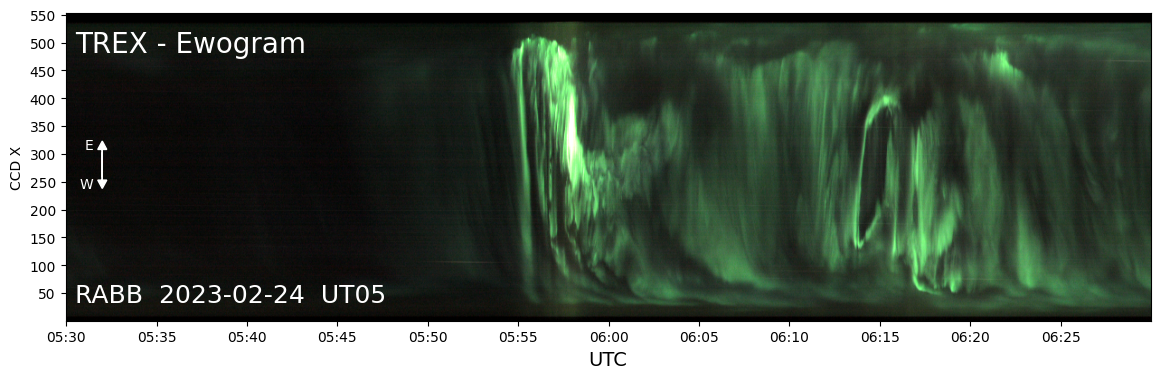

In [38]:
# Ewograms, which are analogous to keograms but composed of horizontal/longitudinal slices of the ASI FOV, can be generated
# using a nearly identical process.

# Here, it is important to note that the height of the ewogram is determined instead by the width of a single ASI image.
# Some instruments do indeed produce images whose dimensions are not square, so it is important to be mindful.
n_columns = img.shape[1]
n_channels = img.shape[2]
n_imgs = img.shape[-1]
ewogram = np.empty([n_columns, n_imgs, n_channels])
time_string_list = list()

# This time, we will use the index of the middle row, as opposed to the middle column.
middle_row_idx = int( (img.shape[0])/2 - 1)
for img_idx in range(0,n_imgs):

    # For each iteration, we slice into 'img' to obtain a single image
    # frame, and then slice into that to obtain the center row:
    frame = img[:,:,:,img_idx]
    frame_middle_slice = frame[middle_row_idx,:,:]

    # *** This is an important step, although it may not be necessary for all cases. One must be careful in how
    #     slices are oriented. Say we wanted our ewogram to be oriented so that the bottom corresponds to western
    #     longitudes, and vice versa. If we insert the above slice directly into the ewogram array as is, this will
    #     not be the case. Consider, the first column of a row would correspond to the westernmost longitude, and
    #     when we insert that into the ewogram, it will appear at the top (first row). This will become more apparent
    #     if someone requires georeferencing, as is often the case, but it is an important point to be weary of as to
    #     not pose a risk to the integrity of your data products. To combat this, we simply flip the slice.
    frame_middle_slice = np.flip(frame_middle_slice)

    # Now. we can insert this slice as the current iteration's column, and update the time string list
    ewogram[:,img_idx,:] = frame_middle_slice
    iter_meta = meta[img_idx]
    timestamp = iter_meta["image_request_start_timestamp"]
    time_string = timestamp[11:16]
    time_string_list.append(time_string)

# Scaling the ewogram
scaled_ewogram = scale_image(ewogram, cmin=10, cmax=100, high=255)

# Obtain metadata for plotting
imager = meta[0]["project_unique_id"]
site = meta[0]["site_unique_id"]
first_timestamp = meta[0]["image_request_start_timestamp"]
date_string = first_timestamp[0:10]
hour_string = first_timestamp[11:13]

# Plotting the ewogram as usual
plt.figure(figsize=(14,4))
plt.imshow(scaled_ewogram, cmap='gist_heat', aspect='auto')
plt.text(10, 70, imager.upper()+' - Ewogram', color='white', fontsize=20)
plt.text(10, 520, site.upper()+'  '+date_string+'  UT'+hour_string, color='white', fontsize=18)
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.yticks(np.arange(n_columns, 0, -50), np.arange(0, n_columns, 50))
plt.ylabel("CCD X")
plt.xlabel("UTC", fontsize=14)

# In this case, it is useful to add a compass to the plot, as to not confuse viewers regarding orientation
plt.arrow(40, 250, 0, 50, color='white', head_width=10)
plt.arrow(40, 295, 0, -50, color='white', head_width=10)
plt.text(20, 245, "E", color='white')
plt.text(15, 315, "W", color='white')
plt.show()